In [2]:
import os
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
#from torchvision.datasets import MNIST
#import torchvision.transforms as transforms
from torch.utils.data import Dataset
import spacy
#import pytorch_lightning as pl
#from pytorch_lightning import Trainer
import matplotlib.pyplot as plt
import numpy as np
from scipy import linalg
import scipy
from sklearn.manifold import TSNE
import sklearn
from sklearn.linear_model import LinearRegression, Ridge, SGDClassifier
from sklearn.svm import LinearSVC, SVR
from sklearn.multioutput import MultiOutputRegressor
#from sklearn.datasets import fetch_mldata
from sklearn.decomposition import PCA
import scipy.io
import random
import inlp
from sklearn.manifold import TSNE
import matplotlib
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import torch
from transformers import BertTokenizer, BertModel, BertForMaskedLM, BertConfig
from typing import Tuple, Dict
from typing import List
import tqdm
from tqdm import tqdm_notebook
import urllib
import time
import pickle
import inlp, inlp_dataset_handler, inlp_linear_model
%load_ext autoreload
%autoreload

/home/nlp/ravfogs/anaconda2/envs/py36/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/nlp/ravfogs/anaconda2/envs/py36/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/nlp/ravfogs/anaconda2/envs/py36/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/nlp/ravfog

In [3]:
def load_wiki(url = "http://nlp.biu.ac.il/~ravfogs/resources/wiki.1million.raw.txt"):
    
  response = urllib.request.urlopen(url)
  raw = response.read().decode('utf8')
  sents = raw.split("\n")
  
  return sents[:]


def create_docs(sentences: List[str]) -> List[spacy.tokens.Doc]:

    #parsing and toekenizing (NOTE: takes about 10 minutes)
    
    nlp = spacy.load('en_core_web_sm')
    nlp.remove_pipe("ner")
    
    start = time.time()
    
    docs = list(nlp.pipe(sentences, batch_size = 100))
    
    docs = list(docs)
    print(time.time() - start)
    
    return docs


def create_dataset_for_related_words(docs, num_samples = 100*1e3, all_descendents = True):
    
    data = []
    pbar = tqdm_notebook(total = num_samples)
    
    while len(data) < num_samples:
        
        doc = random.choice(docs)
        sent = " ".join([tok.text for tok in doc])
        if len(doc) < 9: continue
        
        for i,tok in enumerate(doc):
            pbar.update(2)
            head = tok.head
            
            if all_descendents:
                subtree = list(tok.subtree)
                subtree.remove(tok)
                related = subtree
            else:
                related = list(tok.children)
                
                
            #subtree.remove(tok)
            if len(related) <= 0: continue
                
            random_related = random.choice(related)
            data.append((sent, doc, i, random_related.i, 1))
            
            # choose negative example
            
            chosen = False
            ind = 0
            potentials = []
            
            while not chosen:
                
                random_word = random.choice([t for t in doc])#random.choice([t for t in doc if abs(t.i - tok.i) < d])
                ind += 1
                if ind > 100: break
                if len(potentials) > 10: break
                    
                if random_word not in related:
                    potentials.append((sent, doc, i, random_word.i, 0))
            
            #potentials = [p for p in potentials if p[-3] < p[-2]]
            if potentials:
                potentials = list(sorted(potentials, key = lambda x: abs(x[-3]-x[-2])))
                data.append(random.choice(potentials[:4]))
                
    random.shuffle(data)
    return data



def create_dataset_for_being_in_the_same_subtree(docs, num_samples = 100*1e3):
    
    data = []
    pbar = tqdm_notebook(total = num_samples)
    
    while len(data) < num_samples:
        
        doc = random.choice(docs)
        sent = " ".join([tok.text for tok in doc])
        if len(doc) < 9: continue
        
        for i,tok in enumerate(doc):
            pbar.update(2)
            head = tok.head
            subtree = list(tok.subtree)
            #subtree.remove(tok)
            if len(subtree) <= 1: continue
                
            chosen = False
            while not chosen:
                
                tok1, tok2 = np.random.choice(subtree, size = 2, replace = False)
                if tok1 != tok2:
                    chosen = True
                    
            data.append((sent, doc, tok1.i, tok2.i, 1))
            
            # choose negative example
            
            chosen = False
            if tok1.dep_ == "ROOT": continue
            ind = 0
            potentials = []
            
            while not chosen:
                ind += 1
                if ind > 150: break
                tok = random.choice(doc)
                if tok in list(tok1.subtree) or tok in list(tok2.subtree) or tok1 in list(tok.subtree) or tok2 in list(tok.subtree):
                    continue
                else:
                    potentials.append((sent, doc, tok.i, random.choice([tok1,tok2]).i, 0))
                if len(potentials) > 20: break
            
            if potentials:
                potentials = sorted(potentials, key = lambda x: abs(x[-2]-x[-3]))
                data.append(random.choice(potentials[:6]))
            
    
    random.shuffle(data)
    return data
    
def create_dataset_for_depth(docs, num_samples = 25*1e3):
    
    data = []
    pbar = tqdm_notebook(total = num_samples)
    i = 0
    
    while len(data) < num_samples:
        pbar.update(1)
        i += 1
        doc = random.choice(docs)
        sent = " ".join([tok.text for tok in doc])
        if len(doc) < 9: continue
        
        for i,tok in enumerate(doc):
            depth = 0
            head = tok
            while head.dep_ != "ROOT":
                
                depth += 1
                head = head.head
                
            data.append((sent, doc, i, depth))
    
    random.shuffle(data)
    return data        

## Collect data

In [4]:
#sents = load_wiki()
with open("sents.50k.pickle", "rb") as f:
    
    sents = pickle.load(f)

In [5]:
sents = sents[:50000]
docs = create_docs(sents)

122.8075942993164


In [18]:
data = create_dataset_for_related_words(docs, num_samples = 125 * 1e3, all_descendents = False)
#data = create_dataset_for_being_in_the_same_subtree(docs, num_samples = 75 * 1e3)
#data = create_dataset_for_depth(docs, num_samples = 100000)
print(len(data))

125008


In [19]:
labels = [d[-1] for d in data]
print(sum(labels)/len(labels))

0.5


In [20]:
for i in range(10):
        
        print(data[i])
        print("---------------")

('betty wakes up in bed with all the fairy tale characters surrounding her .', betty wakes up in bed with all the fairy tale characters surrounding her., 3, 6, 0)
---------------
('as of the census of 2000 , there were 1 , 626 people , 644 households , and 455 families residing in the township .', as of the census of 2000, there were 1, 626 people, 644 households, and 455 families residing in the township., 23, 22, 1)
---------------
("hagit ronen maimon , a 43-year - old woman from be'er sheva .", hagit ronen maimon, a 43-year-old woman from be'er sheva., 7, 5, 1)
---------------
("dodiya 's of mewaronce , on a pilgrimage to gujarat , the mother of maharana lakha ( 1382 - 1421 ) of mewar and her party were attacked by dacoits ( bandits ) .", dodiya 's of mewaronce, on a pilgrimage to gujarat, the mother of maharana lakha (1382-1421) of mewar and her party were attacked by dacoits (bandits)., 19, 18, 1)
---------------
('this view is , however , challenged by max holland , author of th

In [21]:
with open("sents.50k.pickle", "wb") as f:
    pickle.dump(sents, f)
    
with open("docs.50k.pickle", "wb") as f:
    pickle.dump(docs, f)

## Encoder

In [15]:
class BertEncoder(object):
    
    def __init__(self, device = 'cpu'):

        config = BertConfig.from_pretrained("bert-base-uncased", output_hidden_states=True)
        self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
        self.model = BertModel.from_pretrained('bert-base-uncased', config = config)
            
        self.model.eval()
        self.model.to(device)
        self.device = device
        
    def tokenize(self, original_sentence: List[str]) -> Tuple[List[str], Dict[int, int]]:

        """
        Parameters
        ----------
        Returns
        -------
        bert_tokens: The sentence, tokenized by BERT tokenizer.
        orig_to_tok_map: An output dictionary consisting of a mapping (alignment) between indices in the original tokenized sentence, and indices in the sentence tokenized by the BERT tokenizer. See https://github.com/google-research/bert
        """

        bert_tokens = ["[CLS]"]
        orig_to_tok_map = {}
        has_subwords = False
        is_subword = []

        for i, w in enumerate(original_sentence):
            tokenized_w = self.tokenizer.tokenize(w)
            has_subwords = len(tokenized_w) > 1
            is_subword.append(has_subwords)
            bert_tokens.extend(tokenized_w)

            orig_to_tok_map[i] = len(bert_tokens) - 1

        bert_tokens.append("[SEP]")
        
        return (bert_tokens, orig_to_tok_map)

    
    def encode(self, sentence: str, layers: List[int]):
        
        tokenized_text, orig2tok = self.tokenize(sentence.split(" "))
        indexed_tokens = self.tokenizer.convert_tokens_to_ids(tokenized_text)
        tokens_tensor = torch.tensor([indexed_tokens]).to(self.device)

        with torch.no_grad():
            outputs = self.model(tokens_tensor)
            predictions = torch.cat([outputs[2][l] for l in layers], axis = 2).detach().cpu().numpy()
            
            """
            if layer >= 0:
                predictions = outputs[2][layer].detach().cpu().numpy()
            else:
                concat = torch.cat(outputs[2], axis = 0)
                concat = concat[:7, :, :]
                predictions = concat.reshape(concat.shape[1], concat.shape[0] * concat.shape[2])
                
                print(predictions.shape)
                print("----------------------------")
                #predictions = torch.sum(concat, axis = 0).detach().cpu().numpy()
            """
            return (predictions.squeeze(), orig2tok)
        

def collect_bert_states_for_grammatical_relation(bert, data: List[Tuple], layers: List[int]):
    
    
    for i,d in tqdm_notebook(enumerate(data), total = len(data)):
        
        sent = d[0]
        doc = d[1]
        j,k = d[2], d[3]
        label = d[4]
        
        preds, orig2tok = bert.encode(sent, layers = layers)

        x1,x2 = preds[orig2tok[j]], preds[orig2tok[k]]
        data[i] = (sent, doc, j, k, x1, x2, label)
    
    return data


def collect_bert_states_for_depth(bert, data: List[Tuple], layers: List[int]):
    
    
    for i,d in tqdm_notebook(enumerate(data), total = len(data)):
        
        sent = d[0]
        doc = d[1]
        jj = d[2]
        label = d[3]
        
        preds, orig2tok = bert.encode(sent, layers = layers)
        v = preds[orig2tok[jj]]
        data[i] = (sent, doc, jj, v, label)
    
    return data
        

In [16]:
bert = BertEncoder(device = "cuda")

I0224 04:22:52.089031 139988754700096 configuration_utils.py:185] loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-config.json from cache at /home/nlp/ravfogs/.cache/torch/transformers/4dad0251492946e18ac39290fcfe91b89d370fee250efe9521476438fe8ca185.8f56353af4a709bf5ff0fbc915d8f5b42bfff892cbb6ac98c3c45f481a03c685
I0224 04:22:52.091067 139988754700096 configuration_utils.py:199] Model config {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "finetuning_task": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "is_decoder": false,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "num_labels": 2,
  "output_attentions": false,
  "

In [78]:
#data_with_states = collect_bert_states_for_depth(bert, data[:], layers = [7])
data_with_states = collect_bert_states_for_grammatical_relation(bert, data[:75000], layers = [7])

In [79]:

for i,d in enumerate(data_with_states):
    #print(i, d)
    assert type(d[-1]) == int

In [80]:
with open("data_with_states.pickle", "wb") as f:
    pickle.dump(data_with_states, f)

In [81]:
random.shuffle(data_with_states)
l = int(len(data_with_states) * 0.8)
train, dev = data_with_states[:l], data_with_states[l:]

In [82]:
with open("data_with_states.pickle", "rb") as f:
    data_with_states = pickle.load(f)
    #data_with_states = data_with_states[:70000]
    
len(data_with_states)

75000

In [83]:
def tsne(vecs, labels, title="", words = None, metric = "l2", color_gradient = False):

  tsne = TSNE(n_components=2, random_state=0, metric = metric)
  vecs_2d = tsne.fit_transform(vecs)
  num_labels = len(set(labels.tolist()))

  #names = ["digit={}".format(int(i)) for i in labels.tolist()]
  #names = ["class {}".format(i) for i in range(num_labels)]
  names = sorted(set(labels.tolist()))
  

  if not color_gradient:
      plt.figure(figsize=(6, 5))
      colors = "red", "green", "blue", "cyan", "yellow", "orange", "brown", "black", "purple", "pink"
      #colors = [(255,13,12) for n in names]
    
      for i, c, label in zip(sorted(set(labels.tolist())), colors, names):
        #print(len(vecs_2d[labels == i, 0]))
        plt.scatter(vecs_2d[labels == i, 0], vecs_2d[labels == i, 1], c=c,
                    label=label, alpha = 0.3)
      plt.legend()
  
  else:
        fig, ax = plt.subplots()
        N = num_labels
        # define the colormap
        cmap = plt.cm.jet
        # extract all colors from the .jet map
        cmaplist = [cmap(i) for i in range(cmap.N)]
        # create the new map
        cmap = cmap.from_list('Custom cmap', cmaplist, cmap.N)
        # define the bins and normalize
        bounds = np.linspace(0, N, N + 1)
        norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)

        scat = ax.scatter(vecs_2d[:, 0], vecs_2d[:, 1], c = labels, cmap=cmap, norm=norm, alpha=0.6)
        cb = plt.colorbar(scat, spacing='proportional', ticks=bounds)
        cb.set_label("label")

  plt.title(title)

## INLP

In [84]:
x_train1, x_train2 = [], []
x_dev1, x_dev2 = [], []
y_train, y_dev = [], []

for _, _, _,_, x1,x2,y in train:
    
    x_train1.append(x1)
    x_train2.append(x2)
    y_train.append(y)
    
for _, _, _,_, x1,x2,y in dev:
    
    x_dev1.append(x1)
    x_dev2.append(x2)
    y_dev.append(y)
    
x_train1, x_train2 = np.array(x_train1), np.array(x_train2)
x_dev1, x_dev2 = np.array(x_dev1), np.array(x_dev2)
y_train, y_dev = np.array(y_train), np.array(y_dev)

inlp_dataset = inlp_dataset_handler.SiameseDatasetHandler((x_train1, x_train2), y_train, (x_dev1, x_dev2), y_dev, dropout_rate = 0, Y_train_main = None, Y_dev_main = None, by_class = False, equal_chance_for_main_task_labels = False)
params = {"num_iter": 4, "input_dim": 768, "hidden_dim": 32, "batch_size": 16, "verbose": False, "device": "cuda",
         "compare_by": "dot_product", "same_weights": False}
inlp_model_handler = inlp_linear_model.SiameseLinearClassifier(model_params = params, concat_weights = False)

In [95]:
P, rowspace_projections, Ws = inlp.run_INLP(num_classifiers = 5, input_dim = 768, is_autoregressive = True, min_accuracy = 0, dataset_handler = inlp_dataset, model = inlp_model_handler)

  0%|          | 0/5 [00:00<?, ?it/s]

PARAMS. same_weights: False, compare_by: dot_product
         Name               Type Params
0          l1             Linear   24 K
1          l2             Linear   24 K
2  cosine_sim   CosineSimilarity    0  
3     loss_fn  BCEWithLogitsLoss    0  
Accuracy is 0.4124999940395355
Accuracy is 0.8600080013275146
Accuracy is 0.8687366843223572
Accuracy is 0.8639392256736755


iteration: 0, accuracy: 0.8628731369972229:   0%|          | 0/5 [01:33<?, ?it/s]

Accuracy is 0.8628731369972229


iteration: 0, accuracy: 0.8628731369972229:  20%|██        | 1/5 [01:35<06:22, 95.69s/it]

PARAMS. same_weights: False, compare_by: dot_product
         Name               Type Params
0          l1             Linear   24 K
1          l2             Linear   24 K
2  cosine_sim   CosineSimilarity    0  
3     loss_fn  BCEWithLogitsLoss    0  
Accuracy is 0.5625
Accuracy is 0.8346881866455078
Accuracy is 0.8492137789726257
Accuracy is 0.8448827266693115


iteration: 1, accuracy: 0.8424840569496155:  20%|██        | 1/5 [03:17<06:22, 95.69s/it]

Accuracy is 0.8424840569496155


iteration: 1, accuracy: 0.8424840569496155:  40%|████      | 2/5 [03:19<04:54, 98.18s/it]

PARAMS. same_weights: False, compare_by: dot_product
         Name               Type Params
0          l1             Linear   24 K
1          l2             Linear   24 K
2  cosine_sim   CosineSimilarity    0  
3     loss_fn  BCEWithLogitsLoss    0  
Accuracy is 0.42500001192092896
Accuracy is 0.8101012706756592
Accuracy is 0.821561872959137
Accuracy is 0.8218950033187866


iteration: 2, accuracy: 0.816964328289032:  40%|████      | 2/5 [05:02<04:54, 98.18s/it] 

Accuracy is 0.816964328289032


iteration: 2, accuracy: 0.816964328289032:  60%|██████    | 3/5 [05:04<03:20, 100.07s/it]

PARAMS. same_weights: False, compare_by: dot_product
         Name               Type Params
0          l1             Linear   24 K
1          l2             Linear   24 K
2  cosine_sim   CosineSimilarity    0  
3     loss_fn  BCEWithLogitsLoss    0  
Accuracy is 0.4375
Accuracy is 0.7898454070091248
Accuracy is 0.8023054599761963
Accuracy is 0.8052372336387634


iteration: 3, accuracy: 0.80330491065979:  60%|██████    | 3/5 [06:36<03:20, 100.07s/it] 

Accuracy is 0.80330491065979


iteration: 3, accuracy: 0.80330491065979:  80%|████████  | 4/5 [06:38<01:38, 98.31s/it] 

PARAMS. same_weights: False, compare_by: dot_product
         Name               Type Params
0          l1             Linear   24 K
1          l2             Linear   24 K
2  cosine_sim   CosineSimilarity    0  
3     loss_fn  BCEWithLogitsLoss    0  
Accuracy is 0.42500001192092896
Accuracy is 0.7738539576530457
Accuracy is 0.7877798676490784
Accuracy is 0.7899120450019836


iteration: 4, accuracy: 0.7948427796363831:  80%|████████  | 4/5 [08:23<01:38, 98.31s/it]

Accuracy is 0.7948427796363831


iteration: 4, accuracy: 0.7948427796363831: 100%|██████████| 5/5 [08:25<00:00, 101.06s/it]


In [96]:
P_rowspace = np.eye(768) - P #np.sum(rowspace_projections, axis = 0)
P_rowspace.dot(P_rowspace) - P_rowspasce

#with open("P_rowspace.is_parent.hidden=32.num_clfs=10.npy", "wb") as f:    
#    np.save(f, P_rowspace)
    
#P_rowspace2 = np.sum(rowspace_projections, axis = 0)
#P_rowspace2.dot(P_rowspace2) - P_rowspace2


def get_rowspace_projection_in_low_dim(Ws, vecs):
    
    projs = []
    for w in Ws:
        
        w_normalized = w/np.linalg.norm(w, keepdims = True, axis = 1)
        proj = w_normalized.dot(vecs.T).T # (n,siamese_dim)
        projs.append(proj)
    
    projs = np.concatenate(projs, axis = 1)
    return projs

## tsne

In [97]:
n = 5000
data_for_tsne = [tup[4] for tup in dev[:n]]
data_for_tsne_docs = [tup[1] for tup in dev[:n]]
data_for_tsne_idx = [tup[2] for tup in dev[:n]]
data_for_tsen_deps = []
to_keep_dep = ["nsubj", "dobj", "pobj", "auxpass", "amod", "ROOT", "prep", "compound"]
#to_keep_dep = ["ROOT", "prep", "nsubj"]
to_keep_pos = ["NOUN", "VERB", "ADJ"]
vecs = []

by = "dep"
from collections import Counter
c = Counter([x.dep_ for doc in data_for_tsne_docs for x in doc])
common_deps, _ = list(zip(*c.most_common(5)))

for doc,i,v in zip(data_for_tsne_docs,data_for_tsne_idx,data_for_tsne):
    
    if by == "dep":
        dep = doc[i].dep_
        c[dep] += 1
        if dep in to_keep_dep:
            data_for_tsen_deps.append(dep)
            vecs.append(v)
            
    elif by == "pos":
        
        pos = doc[i].pos_
        if pos in c.most_cm:
            data_for_tsen_deps.append(pos)
            vecs.append(v)
            
    elif by == "depth":
        
        depth = 0
        head = doc[i]
        
        while head.dep_ != "ROOT":
            
            depth += 1
            if depth > 7: break
            head = head.head
            
        data_for_tsen_deps.append(depth)
        vecs.append(v)

vecs = np.array(vecs)
vecs_rowspace = P_rowspace.dot(vecs.T).T
vecs_rwospace_low_dim = get_rowspace_projection_in_low_dim(Ws, vecs)
data_for_tsen_deps = np.array(data_for_tsen_deps)



print(len(vecs))
assert len(data_for_tsen_deps) == len(vecs)
print(common_deps)

3532
('punct', 'prep', 'pobj', 'det', 'compound')


In [98]:
data_for_tsen_deps[:150]

array(['pobj', 'prep', 'prep', 'prep', 'prep', 'prep', 'nsubj', 'dobj',
       'ROOT', 'pobj', 'ROOT', 'ROOT', 'pobj', 'pobj', 'ROOT', 'prep',
       'ROOT', 'ROOT', 'prep', 'prep', 'nsubj', 'prep', 'pobj', 'prep',
       'prep', 'prep', 'pobj', 'prep', 'prep', 'ROOT', 'ROOT', 'prep',
       'pobj', 'pobj', 'pobj', 'pobj', 'prep', 'ROOT', 'pobj', 'prep',
       'pobj', 'compound', 'pobj', 'prep', 'pobj', 'prep', 'nsubj',
       'dobj', 'ROOT', 'prep', 'pobj', 'prep', 'pobj', 'dobj', 'dobj',
       'prep', 'ROOT', 'prep', 'prep', 'prep', 'amod', 'prep', 'pobj',
       'pobj', 'pobj', 'ROOT', 'ROOT', 'pobj', 'pobj', 'ROOT', 'pobj',
       'pobj', 'nsubj', 'prep', 'prep', 'prep', 'prep', 'pobj', 'prep',
       'prep', 'pobj', 'pobj', 'ROOT', 'prep', 'pobj', 'prep', 'ROOT',
       'prep', 'dobj', 'prep', 'dobj', 'pobj', 'ROOT', 'prep', 'pobj',
       'prep', 'pobj', 'prep', 'nsubj', 'pobj', 'prep', 'prep', 'ROOT',
       'prep', 'pobj', 'prep', 'ROOT', 'ROOT', 'prep', 'ROOT', 'prep',
     

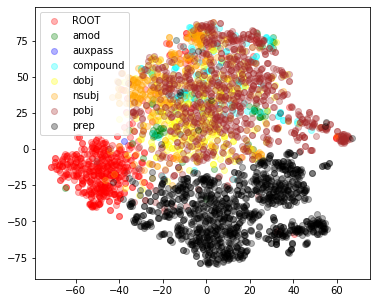

In [99]:
tsne(vecs_rwospace_low_dim[:3500], data_for_tsen_deps[:3500], metric = "l2", color_gradient = False)

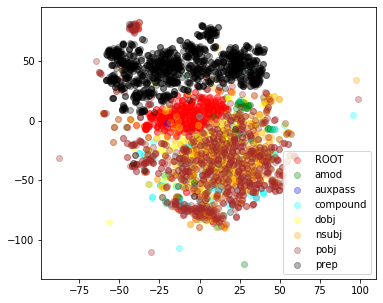

In [100]:
tsne(vecs[:3500], data_for_tsen_deps[:3500], metric = "l2", color_gradient = False)

In [101]:
def compute_v_measure(vecs, labels_true, k=10):
        np.random.seed(0)
        clustering = sklearn.cluster.KMeans(n_clusters = k, random_state = 0)
        clustering.fit(vecs)
        labels_pred = clustering.labels_
        return sklearn.metrics.v_measure_score(labels_true, labels_pred)

In [104]:
k = 100 #len(set(data_for_tsen_deps.tolist()))
v_before = compute_v_measure(vecs, data_for_tsen_deps, k = k )
v_after = compute_v_measure(vecs_rowspace, data_for_tsen_deps, k = k)
print(v_before, v_after)

0.3374211999891492 0.3506922585645656


In [378]:
plot_Vmeasure_by_dim(vecs, vecs_rowspace, data_for_tsen_deps, max_k = 75)

NameError: name 'plot_Vmeasure_by_dim' is not defined

## Classification

In [335]:
train_size = 2000 #int(len(vecs_rowspace) * 0.75)



model = SGDClassifier()
model.fit(vecs[:train_size], data_for_tsen_deps[:train_size])
print(model.score(vecs[train_size:], data_for_tsen_deps[train_size:]))

model = SGDClassifier()
model.fit(vecs_rowspace[:train_size], data_for_tsen_deps[:train_size])
print(model.score(vecs_rowspace[train_size:], data_for_tsen_deps[train_size:]))

0.9032258064516129
0.8306451612903226


In [164]:
data_for_tsen_deps

array(['dobj', 'ROOT', 'pobj', ..., 'pobj', 'prep', 'prep'], dtype='<U8')

In [93]:
vecs_rowspace.shape

(3532, 768)